### EDA su dati da file in **formato Garmin fit**
* mostra come caricare un file in formato fit
* come calcolare alcune statistiche e plottare alcune serie temporali
* come visualizzare il percorso su una mappa interattiva

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# maps
import folium

from utility import load_in_pandas_from_fit, plot_vs_altitude, compute_total_distance, compute_energy_consumed

#### Load the file in a DataFrame

In [3]:
POWER = False
CADENCE = False

FNAME = "luigi18112023.fit"

# specifying true we load also power and cadence
df = load_in_pandas_from_fit(FNAME, power=POWER, cadence=POWER)

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
# tail or head?
df.head(10)

,id,timestamp,position_lat,position_long,altitude,temperature,speed,distance,heart_rate
0,1,2023-11-18 08:01:12,41.864383,12.554881,50.6,14,12.80,4.77,87.0
1,2,2023-11-18 08:01:18,41.864482,12.554661,55.8,14,11.25,26.04,NaN
2,3,2023-11-18 08:01:24,41.864525,12.554468,55.8,14,11.02,42.84,87.0
3,4,2023-11-18 08:01:26,41.864525,12.554417,55.8,14,7.73,47.06,87.0
4,5,2023-11-18 08:01:28,41.864490,12.554376,56.0,14,9.07,52.33,87.0
5,6,2023-11-18 08:01:34,41.864327,12.554284,55.8,14,9.54,71.99,NaN
6,7,2023-11-18 08:01:40,41.864113,12.554177,56.0,14,15.35,97.39,NaN
7,8,2023-11-18 08:01:46,41.863904,12.554038,56.0,14,13.44,123.34,NaN
8,9,2023-11-18 08:01:52,41.863762,12.553937,55.6,14,8.67,141.45,87.0
9,10,2023-11-18 08:01:56,41.863706,12.553903,55.4,14,3.16,148.26,87.0


#### Compute Statistics

In [7]:
all_cols = df.columns
exc_cols = ['id','timestamp','position_lat','position_long']
allow_cols = list(set(all_cols) - set(exc_cols))

# ignored first row, with counts
pd.set_option('display.precision', 1)

df[allow_cols].describe()[1:]

,heart_rate,speed,temperature,altitude,distance
mean,135.3,22.0,15.6,181.2,21073.7
std,27.7,9.2,1.7,109.9,11966.7
min,67.0,0.0,11.0,49.6,4.8
25%,124.0,15.6,14.0,78.4,12550.7
50%,140.0,23.6,16.0,151.6,20783.4
75%,152.0,28.1,17.0,300.9,29909.3
max,181.0,41.7,20.0,420.8,42304.9


In [5]:
# remove when lat, long are nan
df = df.dropna(ignore_index=True)

# time elapsed
time_diff = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]

print(f"Elapsed time: {time_diff}")

# tot km
tot_km = round(compute_total_distance(df)/1000., 2)

print(f"Tot km. travelled: {tot_km}")

# va aggiunto il metabolismo basale (sono solo le calorie portate ai pedali)
# enhanced using eff factor (default = 0.25)
# we're assuming time between points is 1 sec.
if POWER:
    print(f"Tot active cal. consumed: {compute_energy_consumed(df, 'power'):.0f} kcal.")

Elapsed time: 0 days 02:36:55
Tot km. travelled: 42.3


#### Some plots

In [6]:
if POWER:
    plot_vs_altitude(df, col_name='n_power', smooth=True)

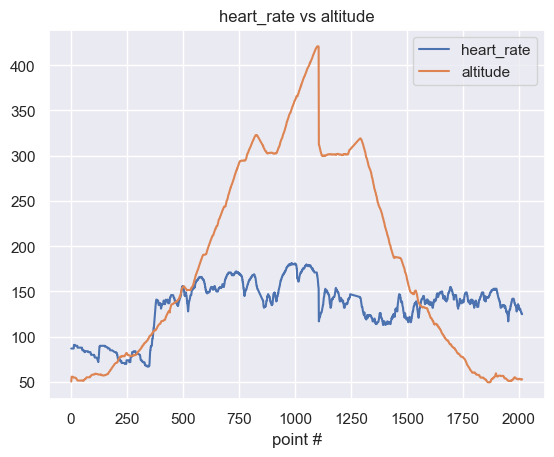

In [7]:
plot_vs_altitude(df, col_name='heart_rate')

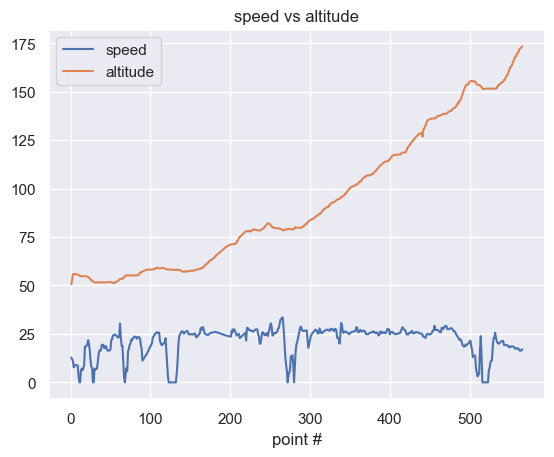

In [8]:
# to reduce # of points
plot_vs_altitude(df[:500], col_name='speed')

#### Displays trackpoints on a map

In [9]:
# remove eventually rows where lat, lon are nan
df = df.dropna(ignore_index=True)

m = folium.Map(location=[df['position_lat'][1], df['position_long'][1]], zoom_start=15)

# to create the popup
cols_list = ['position_lat', 'position_long', 'altitude', 'speed', 'heart_rate']
if POWER:
    cols_list.append('power')
if CADENCE:
    cols_list.append('cadence')
    
for i, row in df[cols_list].iterrows():
    f_str = f"<b>Altitude: {row['altitude']:.1f} m.</b><br><b>Speed: {row['speed']:.1f} kmh</b><br><b>HR: {row['heart_rate']:.0f}</b>"

    if POWER:
        f_str += f"<br><b>Power: {row['power']} w."
    if CADENCE:
        f_str += f"<br><b>Cadence: {row['cadence']}"
        
    popup_html = folium.Popup(f_str, max_width=200)
    
    folium.CircleMarker(location=[row['position_lat'], row['position_long']],
                        popup=popup_html,
                        radius=3).add_to(m)

n_rows = i

# add start (green) end (red)
folium.CircleMarker(
    location=[df['position_lat'][0], df['position_long'][0]],  # Latitude and Longitude
    radius=5,  # Size of the circle
    color='green',  # Border color of the circle
    fill=True,
    fill_color='green'  # Fill color of the circle
).add_to(m)
folium.CircleMarker(
    location=[df['position_lat'][n_rows], df['position_long'][n_rows]],  # Latitude and Longitude
    radius=5,  # Size of the circle
    color='red',  # Border color of the circle
    fill=True,
    fill_color='red'  # Fill color of the circle
).add_to(m)

# display the map
m